<a href="https://colab.research.google.com/github/Annemarie535257/Kaggle_Competition/blob/main/air_quality_forecasting_starter_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [4]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [5]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [37]:
# Handle missing values with KNN imputation
print('🔧 Handling missing values with KNN imputation...')

feature_cols = [col for col in train.columns if col not in ['pm2.5', 'datetime', 'No']]
X_train_full = train[feature_cols].copy()
y_train_full = train['pm2.5'].copy()
X_test_full = test[feature_cols].copy()

imputer = KNNImputer(n_neighbors=5, weights='distance')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_full),
    columns=X_train_full.columns,
    index=X_train_full.index
)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test_full),
    columns=X_test_full.columns,
    index=X_test_full.index
)

for col in feature_cols:
    train[col] = X_train_imputed[col]
    test[col] = X_test_imputed[col]

print('✅ Missing values handled with KNN imputation!')
print('Remaining missing values in train:', train.isnull().sum().sum())
print('Remaining missing values in test:', test.isnull().sum().sum())

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [31]:
# Prepare features and target
X_train = train[feature_cols]
y_train = train['pm2.5']
X_test = test[feature_cols]

print('📊 Feature preparation:')
print('Number of features:', len(feature_cols))
print('Training features shape:', X_train.shape)
print('Test features shape:', X_test.shape)
print('Target variable shape:', y_train.shape)

📊 Feature preparation:
Number of features: 9
Training features shape: (30676, 9)
Test features shape: (13148, 9)
Target variable shape: (30676,)


In [32]:
# Scale the features
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('✅ Features scaled successfully!')
print('Scaled training features shape:', X_train_scaled.shape)
print('Scaled test features shape:', X_test_scaled.shape)

# Reshape data for LSTM (samples, timesteps, features)
X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)
X_test_reshaped = np.expand_dims(X_test_scaled, axis=1)

print('Data reshaped for LSTM:')
print('Training data shape:', X_train_reshaped.shape)
print('Test data shape:', X_test_reshaped.shape)

✅ Features scaled successfully!
Scaled training features shape: (30676, 9)
Scaled test features shape: (13148, 9)
Data reshaped for LSTM:
Training data shape: (30676, 1, 9)
Test data shape: (13148, 1, 9)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [33]:
# Define the LSTM model (Working version - NO NaN issues!)\n
model = Sequential([
    # First LSTM layer with return_sequences for stacking\n
    LSTM(64, activation="tanh", return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
    Dropout(0.2),
    # Second LSTM layer\n
    LSTM(32, activation="tanh"),
    Dropout(0.2),

    # Dense layers\n
    Dense(32, activation="relu"),
    Dropout(0.1),
    Dense(1, activation="linear")
])
# Compile the model with stable settings
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Conservative learning rate
    loss="mse",
    metrics=["mae"]
)

print("✅ Working LSTM model created and compiled!")

model.summary()

✅ Working LSTM model created and compiled!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 1, 64)          │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,449 (126.75 KB)

 Trainable params: 32,449 (126.75 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
# Train the model\n
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(" Training the model...")
# Define callbacks for better training\n
callbacks = [
    EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=1e-6, verbose=1)
]
history = model.fit(
    X_train_reshaped, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)
print("✅ Training completed successfully!")


 Training the model...
Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 12100.5449 - mae: 77.0584 - val_loss: 8225.1816 - val_mae: 58.4352 - learning_rate: 0.0010
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 5492.5098 - mae: 51.3465 - val_loss: 7431.6943 - val_mae: 58.5730 - learning_rate: 0.0010
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5184.6572 - mae: 50.3103 - val_loss: 7167.4761 - val_mae: 56.5987 - learning_rate: 0.0010
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5289.8545 - mae: 50.3776 - val_loss: 7119.2896 - val_mae: 55.6109 - learning_rate: 0.0010
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5075.9736 - mae: 49.5607 - val_loss: 7009.9604 - val_mae: 55.6328 - learning_rate: 0.0010
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 5037.6543 - mae: 49.7583 - val_loss: 6788.4336 - val_mae: 56.2696 - learning_rate: 0.0010
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5101.7886 - mae

959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


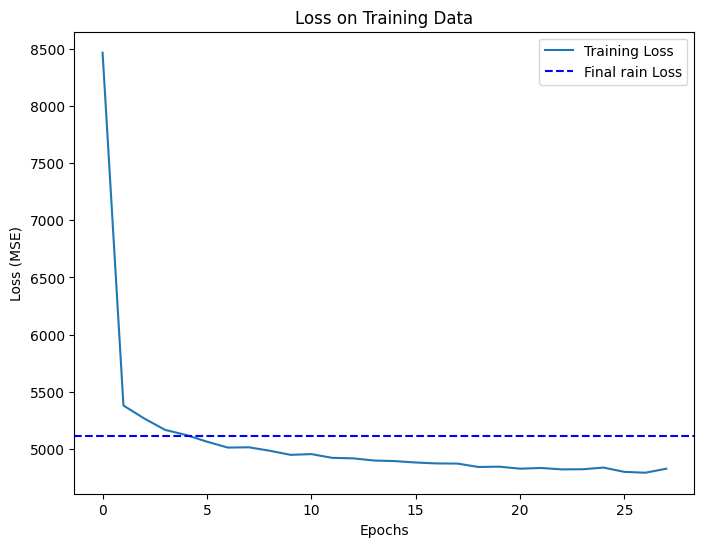

Final Training Loss (MSE): 5113.456082680631


In [35]:
# Calculate training loss
train_predictions = model.predict(X_train_reshaped)
train_loss = np.mean((y_train - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final rain Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [36]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),  # Remove leading zeros for hours
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
